# Processing and narrating a video with GPT's visual capabilities and the TTS API

This notebook demonstrates how to use GPT's visual capabilities with a video. GPT-4 doesn't take videos as input directly, but we can use vision and the new 128K context window to describe the static frames of a whole video at once. We'll walk through two examples:

1. Using GPT-4 to get a description of a video
2. Generating a voiceover for a video with GPT-4 and the TTS API


In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video, to install !pip install opencv-python
import base64
import time
from openai import OpenAI
import os
import requests

client = OpenAI()


## 1. Using GPT's visual capabilities to get a description of a video


First, we use OpenCV to extract frames from a nature [video](https://www.youtube.com/watch?v=kQ_7GtE529M) containing bisons and wolves:


In [2]:
video = cv2.VideoCapture("data/bison.mp4")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")


618 frames read.


Display frames to make sure we've read them in correctly:


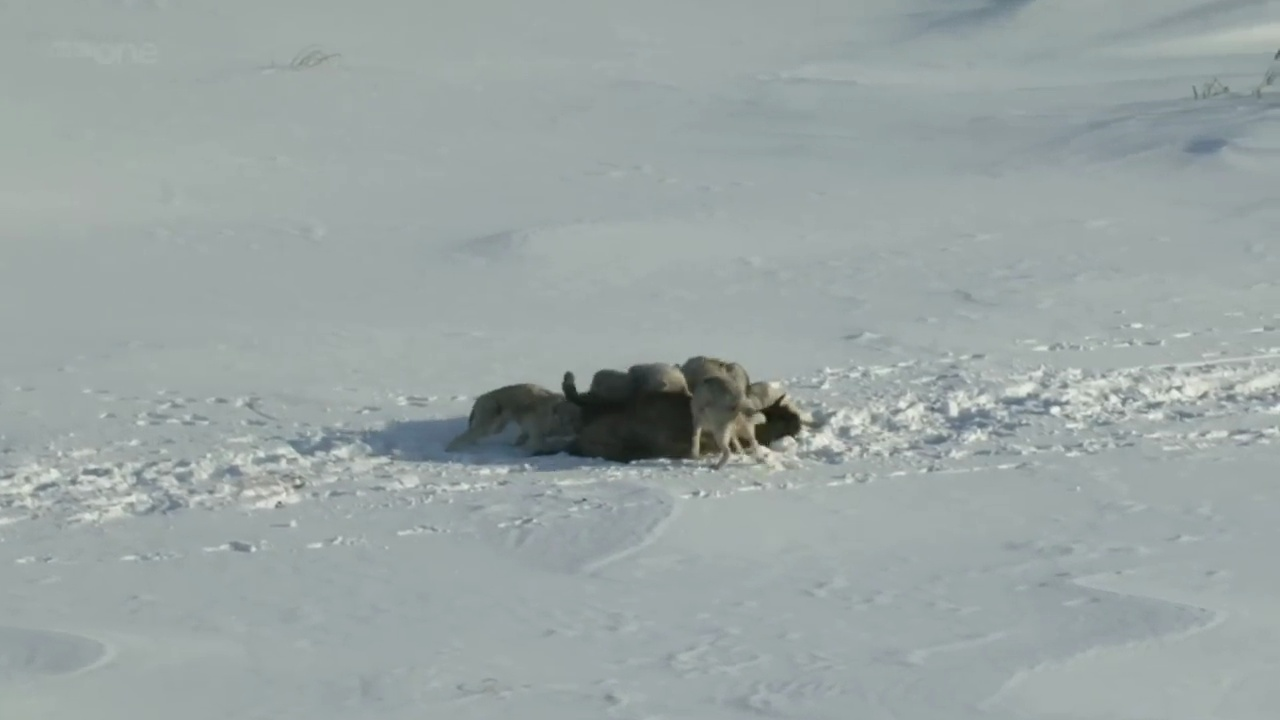

In [3]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)


Once we have the video frames, we craft our prompt and send a request to GPT (Note that we don't need to send every frame for GPT to understand what's going on):


In [4]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames from a video that I want to upload. Generate a compelling description that I can upload along with the video.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 200,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


Title: "Survival in the Snow: The Thrilling Hunt of Wolves vs Bison"

Description: "Immerse yourself in the raw beauty and sheer force of nature with this gripping video showcasing a pack of wolves on the hunt in a snow-covered wilderness. Witness the intense struggle for survival as these cunning predators work together to challenge a formidable bison. This rare footage captures the heart-pounding dynamics between hunter and prey amidst a stunning winter landscape. Every frame is a testament to the resilience and instinct that drives the wild. Watch the dance of life and death unfold in this captivating display of wildlife interaction. Don't forget to like, share, and subscribe for more breathtaking nature encounters!"

Remember to respect wildlife and consider the sensitivity of some viewers when sharing content like this. It's important to provide educational or scientific context to help viewers understand the natural behaviors of wildlife within their ecosystems.


## 2. Generating a voiceover for a video with GPT-4 and the TTS API


Let's create a voiceover for this video in the style of David Attenborough. Using the same video frames we prompt GPT to give us a short script:


In [5]:
PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [
            "These are frames of a video. Create a short voiceover script in the style of David Attenborough. Only include the narration.",
            *map(lambda x: {"image": x, "resize": 768}, base64Frames[0::60]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "max_tokens": 500,
}

result = client.chat.completions.create(**params)
print(result.choices[0].message.content)


In the vast expanse of the snow-covered plains, drama unfolds as the circle of life pits two remarkable species in a struggle for survival. Here we see a pack of wolves, these cunning predators have isolated a bison from the herd, their strategy is as brutal as it is effective.

The wolves work in unison, each member knows its role. Harassing and tiring their prey is their game. As the bison fights to fend off the attackers from every direction, its strength and stamina dwindle. The relentless wolves, embodying resilience and perseverance, continue their assault. Such encounters can last for many exhausting hours under the cold gaze of the winter sun.

As the struggle continues, the snow beneath them is churned into a blizzard of powder. The bison, desperate to protect its own life, swings its massive head, trying to keep the wolves at bay. But the pack senses victory - every snap of their jaws is measured, every darting movement calculated.

Despite the bison's formidable size and pow

Now we can pass the script to the TTS API where it will generate an mp3 of the voiceover:


In [8]:
response = requests.post(
    "https://api.openai.com/v1/audio/speech",
    headers={
        "Authorization": f"Bearer {os.environ['OPENAI_API_KEY']}",
    },
    json={
        "model": "tts-1-1106",
        "input": result.choices[0].message.content,
        "voice": "onyx",
    },
)

audio = b""
for chunk in response.iter_content(chunk_size=1024 * 1024):
    audio += chunk
Audio(audio)
